# Weather Station Clustering 

##DBSCAN using python & scikit-learn¶

Created by: Saeed Aghabozorgi, Polong Lin

### About Dataset

Environment Canada		  
Monthly Values for July - 2015	  	
		
Legend  		
Stn_Name::::	Station Name  
Lat	    ::::	Latitude (North + , degrees)  
Long	::::	Longitude (West - , degrees)  
Prov	::::	Province  
Tm	    ::::	Mean Temperature (Â°C)  
DwTm	::::	Days without Valid Mean Temperature  
D	    ::::	Mean Temperature difference from Normal (1981-2010) (Â°C)  
Tx	    ::::	Highest Monthly Maximum Temperature (Â°C)  
DwTx	::::	Days without Valid Maximum Temperature  
Tn	    ::::	Lowest Monthly Minimum Temperature (Â°C)  
DwTn	::::	Days without Valid Minimum Temperature  
S	    ::::	Snowfall (cm)  
DwS	    ::::	Days without Valid Snowfall  
S%N	    ::::	Percent of Normal (1981-2010) Snowfall  
P	    ::::	Total Precipitation (mm)  
DwP	    ::::	Days without Valid Precipitation  
P%N	    ::::	Percent of Normal (1981-2010) Precipitation  
S_G  	::::	Snow on the ground at the end of the month (cm)  
Pd	    ::::	Number of days with Precipitation 1.0 mm or more  
BS	    ::::	Bright Sunshine (hours)  
DwBS	::::	Days without Valid Bright Sunshine  
BS%  	::::	Percent of Normal (1981-2010) Bright Sunshine  
HDD 	::::	Degree Days below 18 Â°C  
CDD	    ::::	Degree Days above 18 Â°C  
Stn_No	::::	Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).  
NA	    ::::	Not Available  

### 1-Download data into your Data Scientist Workbench

In [1]:
!wget -O /resources/weather-stations20140101-20141231.csv https://ibm.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv

--2015-10-12 19:51:38--  https://ibm.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv
Resolving ibm.box.com... 74.112.184.85, 74.112.185.182
Connecting to ibm.box.com|74.112.184.85|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ibm.app.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv [following]
--2015-10-12 19:51:39--  https://ibm.app.box.com/shared/static/mv6g5p1wpmpvzoz6e5zgo47t44q8dvm0.csv
Resolving ibm.app.box.com... 74.112.184.87, 74.112.185.87
Connecting to ibm.app.box.com|74.112.184.87|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.boxcloud.com/d/1/DzX7iGeIMhakJgnrs_lzJaYdFphG9Twql8xw8jrP1FHog-yp6EK0vniHlaFsE86fg-6wfD9lOhPWk1rNg7n7TEvQmjnWaSnBa4UKdXRiD-DMIgA4AYan7G3ibAtZCm1r5iBfaOQENXlDqWRvBORq-4mT_0RCa2JA1EEkgCzycEgmBOwcWMmeBdMER3Fa24cY0S9qfV3n04Uv_FMVOgkfJejToCvNLYN8dlJqm4mAi4QBROliHACgz9VXwGwCpgE0slm9NdJe1J27NvsvWUZzxLG4iDby7Z12p0pj9X7068GEZtB9OZMPbKpp3QsryZZXkO8-wQ_B2MaOpC

### 2- Load the dataset

In [2]:
import csv
import pandas as pd
import numpy as np

filename='/resources/weather-stations20140101-20141231.csv'

#Read csv
pdf = pd.read_csv(filename)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0,NaN,13.5,0,1.0,...,0,NaN,0,12,NaN,NaN,NaN,273.3,0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0,3.0,15.0,0,-3.0,...,0,104,0,12,NaN,NaN,NaN,307.0,0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13,2.8,16.0,9,-2.5,...,9,NaN,NaN,11,NaN,NaN,NaN,168.1,0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2,3.4,14.5,2,-1.0,...,2,NaN,NaN,11,NaN,NaN,NaN,267.7,0,1012573


### 3-Cleaning

In [3]:
pdf=pdf[pd.notnull(pdf["Tm"])]
pdf = pdf.reset_index(drop=True)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0,NaN,13.5,0,1.0,...,0,NaN,0,12,NaN,NaN,NaN,273.3,0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0,3.0,15.0,0,-3.0,...,0,104,0,12,NaN,NaN,NaN,307.0,0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13,2.8,16.0,9,-2.5,...,9,NaN,NaN,11,NaN,NaN,NaN,168.1,0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2,3.4,14.5,2,-1.0,...,2,NaN,NaN,11,NaN,NaN,NaN,267.7,0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0,NaN,13.1,0,1.9,...,8,NaN,NaN,12,NaN,NaN,NaN,258.6,0,1012710


### 4-Visualization

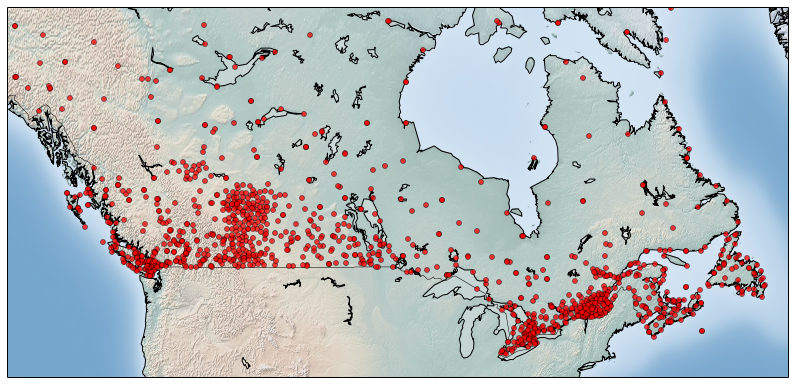

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm']= xs.tolist()
pdf['ym'] =ys.tolist()

#Visualization1
for index,row in pdf.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()



### 5- Clustering of stations based on their location i.e. Lat & Lon

In [5]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = zip(np.asarray(pdf.xm),np.asarray(pdf.ym))
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet=StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


### 6- Visualization of clusters based on location

Cluster 0, Avg Temp: -5.53874755382
Cluster 1, Avg Temp: 1.95263157895
Cluster 2, Avg Temp: -9.19565217391
Cluster 3, Avg Temp: -15.3008333333
Cluster 4, Avg Temp: -7.76904761905


/Library/Python/2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


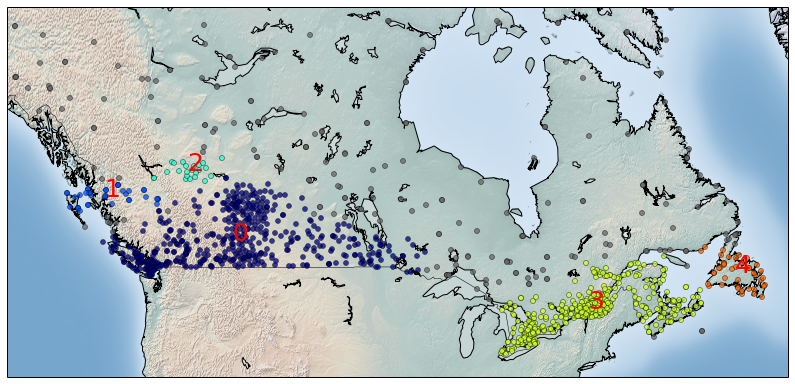

In [6]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for index,row in pdf.iterrows():
    c=(([0.4,0.4,0.4]) if row.Clus_Db<0 else colors[np.float(row.Clus_Db)])
    my_map.plot(row.xm, row.ym,markerfacecolor =c,  marker='o', markersize= 5, alpha = 0.75)

for i in range(realClusterNum): 
    cluster=pdf[["Stn_Name","Tm","xm","ym","Clus_Db"]][pdf.Clus_Db==i]
    cenx=np.mean(cluster.xm) 
    ceny=np.mean(cluster.ym) 
    plt.text(cenx,ceny,str(i), fontsize=25, color='red',)
    print "Cluster "+str(i)+', Avg Temp: '+ str(np.mean(cluster.Tm))


### 7- Clustering of stations based on their location and Temperature

In [7]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = zip(np.asarray(pdf.xm),np.asarray(pdf.ym),np.asarray(pdf.Tx),np.asarray(pdf.Tn),np.asarray(pdf.Tm))
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet=StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


### 8- Visualization of clusters based on location and Temperture


Cluster 0, Avg Temp: 6.22119205298
Cluster 1, Avg Temp: 6.79
Cluster 2, Avg Temp: -0.494117647059
Cluster 3, Avg Temp: -13.8772093023
Cluster 4, Avg Temp: -4.1862745098
Cluster 5, Avg Temp: -16.3015037594
Cluster 6, Avg Temp: -13.6
Cluster 7, Avg Temp: -9.75333333333
Cluster 8, Avg Temp: -4.25833333333


/Library/Python/2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


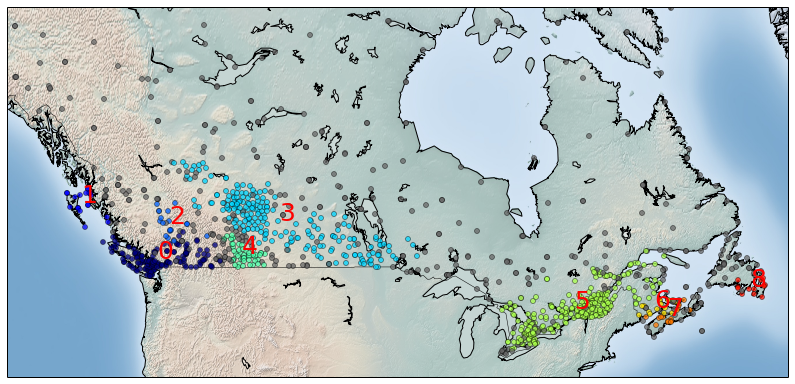

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for index,row in pdf.iterrows():
    c=(([0.4,0.4,0.4]) if row.Clus_Db<0 else colors[np.float(row.Clus_Db)])
    my_map.plot(row.xm, row.ym,markerfacecolor =c,  marker='o', markersize= 5, alpha = 0.75)

for i in range(realClusterNum): 
    cluster=pdf[["Stn_Name","Tm","xm","ym","Clus_Db"]][pdf.Clus_Db==i]
    cenx=np.mean(cluster.xm) 
    ceny=np.mean(cluster.ym) 
    plt.text(cenx,ceny,str(i), fontsize=25, color='red',)
    print "Cluster "+str(i)+', Avg Temp: '+ str(np.mean(cluster.Tm))